# Importing Libraries 

In [24]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

# Loading Data from csv file

In [25]:
df_tc=pd.read_csv('C:/Users/Faisal-Aakon/Desktop/testCase.csv') #df_tc for dataframe of test & case

In [26]:
df_tc.head() #checking the data

,date,case,day,tested
0,3/8/2020,3,1,9
1,3/9/2020,0,2,7
2,3/10/2020,0,3,10
3,3/11/2020,0,4,10
4,3/12/2020,0,5,16


so we get  'date' , 'case' , 'day' , 'tested' columns.


# Here we are going to predict the Confirm cases using test cases

In [27]:
bd_cases = []
bd_tested=[]
bd_dayno=[]

for rate in df_tc.case:
    bd_cases.append(rate) #extracting confirm cases as an array

for rate in df_tc.tested:
    bd_tested.append(rate) #extracting conducted  as an array

for rate in df_tc.day:
    bd_dayno.append(rate) #extracting conducted  as an array


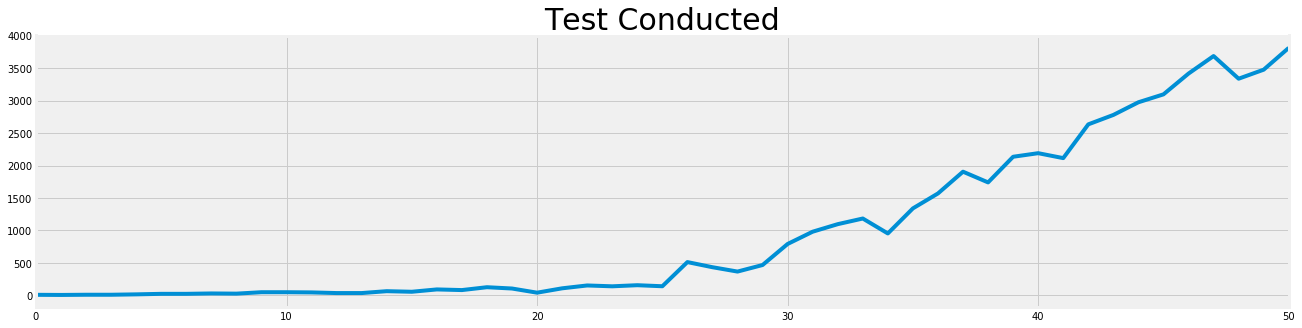

In [28]:
df_tc.tested.plot(figsize=(20,5))

plt.title('Test Conducted', size=30)
plt.show()

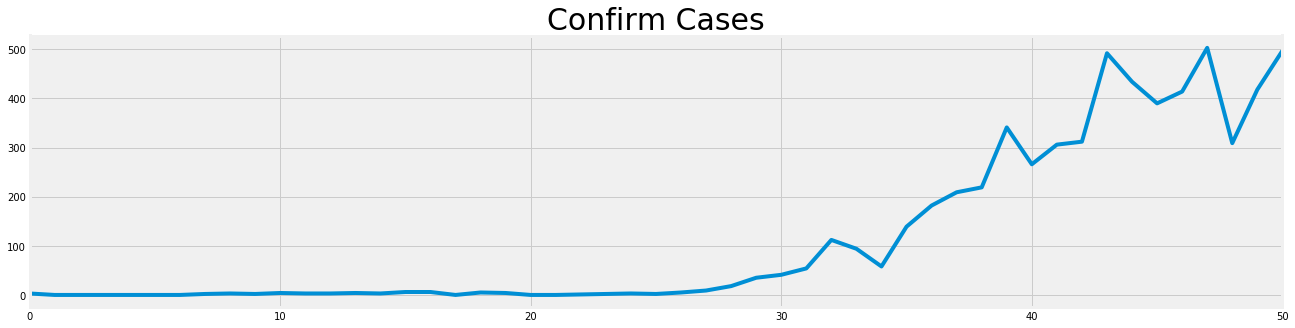

In [29]:
df_tc.case.plot(figsize=(20,5))

plt.title('Confirm Cases', size=30)
plt.show()

Here we are cutting of first 20 days of data , because those data is not relavant for current situation.

In [30]:
bd_cases=bd_cases[20:]
bd_tested=bd_tested[20:]
bd_dayno=bd_dayno[20:]

In [31]:
bd_tested_np=np.array(bd_tested).reshape(-1,1) #converting array as numpy array 

Splitting data into test and train set. We are keeping 20% as test data.

In [32]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(bd_tested_np, bd_cases, test_size=0.20, shuffle=False)

Here we are fixing some test amount to predict against with. 

In [33]:
days_in_future = 5
#future_forcast = np.array([bd_tested.append(bd_tested[-1]+100) for i in range(days_in_future)]).reshape(-1, 1)
future_forcast=bd_tested
# future_forcast.append(3600)
for i in range(days_in_future):
    future_forcast.append(int(future_forcast[-1])+100)
    
future_forcast=np.array(future_forcast).reshape(-1,1)


# bayesian ridge polynomial regression

In [34]:
bayesian_poly = PolynomialFeatures(degree=1)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)
type(bayesian_poly_X_test_confirmed)

numpy.ndarray

In [35]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=2)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.0s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                 

In [36]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 38.081468138650386
MSE: 2695.8872852746254


[498.5244646535619, 511.26801400984226, 524.0115633661227, 536.755112722403, 549.4986620786834]
[[3912]
 [4012]
 [4112]
 [4212]
 [4312]]


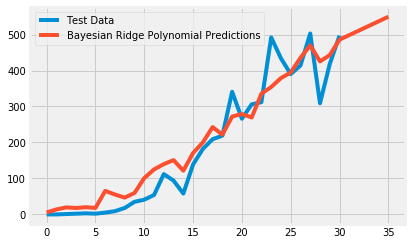

In [37]:
a=[float(v) for v in bayesian_pred]
plt.plot(bd_cases)
plt.plot(a)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])
print(a[-5:])
print(future_forcast[-5:])

# Linear Regression

In [38]:
poly = PolynomialFeatures(degree=1)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)
bd_cases=np.array(bd_cases).reshape(-1, 1)
poly_bd_confirmed = poly.fit_transform(bd_cases)
# poly_future_forcast
# future_forcast

In [39]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 59.793509357617395
MSE: 5527.404310036133


[555.668144848133, 571.0267748152484, 586.3854047823637, 601.744034749479, 617.1026647165943]
[[3912]
 [4012]
 [4112]
 [4212]
 [4312]]


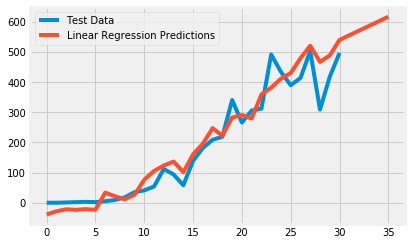

In [40]:
a=[float(v) for v in linear_pred]

plt.plot(bd_cases)
plt.plot(a)
plt.legend(['Test Data', 'Linear Regression Predictions'])
print(a[-5:])
print(future_forcast[-5:])